## Desafio 9 - Classificação com os dados do ENEM 2016

*Jéssica Ramos*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics

### Base de dados

A base de dados que será utilizada é a mesma do desafio anterior, porém com um *target* diferente.

In [2]:
# dados de treino
treino = pd.read_csv('train.csv')

treino.shape

(13730, 167)

In [3]:
# dados de teste
teste = pd.read_csv('test.csv')

teste.shape

(4570, 43)

O primeiro passo é verificar se existem dados ausentes na coluna do *target*.

In [4]:
treino['IN_TREINEIRO'].isna().sum()

0

Como não há nenhum dado ausente, o segundo passo é selecionar as *features* que serão utilizadas. Como as bases de treino e teste têm número distinto de colunas, serão consideradas apenas as colunas em comum nas duas bases.

In [5]:
# lista as colunas em comum
colunas_treino = treino.columns
colunas_teste = teste.columns

colunas_comum = list(set(colunas_teste).intersection(colunas_treino))
colunas_comum.sort()
colunas_comum

['CO_UF_RESIDENCIA',
 'IN_BAIXA_VISAO',
 'IN_CEGUEIRA',
 'IN_DISCALCULIA',
 'IN_DISLEXIA',
 'IN_GESTANTE',
 'IN_IDOSO',
 'IN_SABATISTA',
 'IN_SURDEZ',
 'NU_IDADE',
 'NU_INSCRICAO',
 'NU_NOTA_CH',
 'NU_NOTA_CN',
 'NU_NOTA_COMP1',
 'NU_NOTA_COMP2',
 'NU_NOTA_COMP3',
 'NU_NOTA_COMP4',
 'NU_NOTA_COMP5',
 'NU_NOTA_LC',
 'NU_NOTA_REDACAO',
 'Q001',
 'Q002',
 'Q006',
 'Q024',
 'Q025',
 'Q026',
 'Q027',
 'Q047',
 'SG_UF_RESIDENCIA',
 'TP_ANO_CONCLUIU',
 'TP_COR_RACA',
 'TP_DEPENDENCIA_ADM_ESC',
 'TP_ENSINO',
 'TP_ESCOLA',
 'TP_LINGUA',
 'TP_NACIONALIDADE',
 'TP_PRESENCA_CH',
 'TP_PRESENCA_CN',
 'TP_PRESENCA_LC',
 'TP_PRESENCA_MT',
 'TP_SEXO',
 'TP_STATUS_REDACAO',
 'TP_ST_CONCLUSAO']

In [6]:
# quantidade de colunas
len(colunas_comum)

43

A variável `NU_INSCRICAO` será removida por se tratar do número de inscrição do aluno. Além disso, a variável `CO_UF_RESIDENCIA` será removida pois contém a mesma informação da variável `SG_UF_RESIDENCIA`.

In [7]:
# cria lista de features
features = colunas_comum.copy()

# remove as features citadas
features.remove('NU_INSCRICAO')
features.remove('CO_UF_RESIDENCIA')

len(features)

41

Também serão removidas as variáveis que indicam pedidos de atendimento especializado.

In [8]:
# remove as features de atendimento especializado
r1 = ('IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_DISCALCULIA', 'IN_DISLEXIA', 'IN_GESTANTE',
      'IN_IDOSO', 'IN_SABATISTA', 'IN_SURDEZ')

for elem in r1:
    features.remove(elem)

len(features)

33

Agora é necessário verificar se existem dados ausentes nas features restantes.

In [9]:
treino[features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13730 entries, 0 to 13729
Data columns (total 33 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   NU_IDADE                13730 non-null  int64  
 1   NU_NOTA_CH              10341 non-null  float64
 2   NU_NOTA_CN              10341 non-null  float64
 3   NU_NOTA_COMP1           10133 non-null  float64
 4   NU_NOTA_COMP2           10133 non-null  float64
 5   NU_NOTA_COMP3           10133 non-null  float64
 6   NU_NOTA_COMP4           10133 non-null  float64
 7   NU_NOTA_COMP5           10133 non-null  float64
 8   NU_NOTA_LC              10133 non-null  float64
 9   NU_NOTA_REDACAO         10133 non-null  float64
 10  Q001                    13730 non-null  object 
 11  Q002                    13730 non-null  object 
 12  Q006                    13730 non-null  object 
 13  Q024                    13730 non-null  object 
 14  Q025                    13730 non-null

As variáveis `Q027`, `TP_DEPENDENCIA_ADM_ESC` e `TP_ENSINO` contém dados ausentes em mais da metade das observações e, portanto, serão removidas.

In [10]:
# remove as features com muitos dados ausentes
r2 = ('Q027','TP_DEPENDENCIA_ADM_ESC','TP_ENSINO')

for elem in r2:
    features.remove(elem)

len(features)

30

As variáveis `NU_NOTA_CH`, `NU_NOTA_CN`, `NU_NOTA_COMP1`, `NU_NOTA_COMP2`, `NU_NOTA_COMP3`, `NU_NOTA_COMP4`, `NU_NOTA_COMP5`, `NU_NOTA_LC` e `NU_NOTA_REDACAO` têm alguns dados ausentes. Como são dados de notas, é razoável assumir que o candidato não realizou a prova. Portanto, a nota será substituída pela nota 0.

In [11]:
# número de NaN
i1 = ('NU_NOTA_CH','NU_NOTA_CN','NU_NOTA_COMP1','NU_NOTA_COMP2','NU_NOTA_COMP3',
      'NU_NOTA_COMP4','NU_NOTA_COMP5','NU_NOTA_LC','NU_NOTA_REDACAO')

for var in i1:
    print(var, treino[var].isna().sum())

NU_NOTA_CH 3389
NU_NOTA_CN 3389
NU_NOTA_COMP1 3597
NU_NOTA_COMP2 3597
NU_NOTA_COMP3 3597
NU_NOTA_COMP4 3597
NU_NOTA_COMP5 3597
NU_NOTA_LC 3597
NU_NOTA_REDACAO 3597


In [12]:
# substitui os NaN por 0
for var in i1:
    treino[var].fillna(0, inplace = True)

A variável `TP_STATUS_REDACAO` também contém dados ausentes na base de treino. Como se trata de uma variável categórica (não no tipo ainda, mas pela definição do dicionário de variáveis), vamos inserir a categoria 99 que significa que o dado está ausente para aquele candidato.

In [13]:
# substitui NA por 99
treino['TP_STATUS_REDACAO'].fillna(99, inplace=True)

Também é importante verificar os dados ausentes na base de teste.

In [14]:
teste[features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4570 entries, 0 to 4569
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NU_IDADE           4570 non-null   int64  
 1   NU_NOTA_CH         3458 non-null   float64
 2   NU_NOTA_CN         3458 non-null   float64
 3   NU_NOTA_COMP1      3400 non-null   float64
 4   NU_NOTA_COMP2      3400 non-null   float64
 5   NU_NOTA_COMP3      3400 non-null   float64
 6   NU_NOTA_COMP4      3400 non-null   float64
 7   NU_NOTA_COMP5      3400 non-null   float64
 8   NU_NOTA_LC         3400 non-null   float64
 9   NU_NOTA_REDACAO    3400 non-null   float64
 10  Q001               4570 non-null   object 
 11  Q002               4570 non-null   object 
 12  Q006               4570 non-null   object 
 13  Q024               4570 non-null   object 
 14  Q025               4570 non-null   object 
 15  Q026               4570 non-null   object 
 16  Q047               4570 

Há dados ausentes nas variáveis de nota e na variável `TP_STATUS_REDACAO`. Portanto, faremos as mesmas substituições que fizemos para essas variáveis na base de treino.

In [15]:
# número de NaN
i2 = ('NU_NOTA_CH','NU_NOTA_CN','NU_NOTA_COMP1','NU_NOTA_COMP2','NU_NOTA_COMP3',
      'NU_NOTA_COMP4','NU_NOTA_COMP5','NU_NOTA_LC','NU_NOTA_REDACAO')

for var in i2:
    print(var, teste[var].isna().sum())

NU_NOTA_CH 1112
NU_NOTA_CN 1112
NU_NOTA_COMP1 1170
NU_NOTA_COMP2 1170
NU_NOTA_COMP3 1170
NU_NOTA_COMP4 1170
NU_NOTA_COMP5 1170
NU_NOTA_LC 1170
NU_NOTA_REDACAO 1170


In [16]:
# substitui os NaN por 0
for var in i2:
    teste[var].fillna(0, inplace = True)

In [17]:
# substitui NA por 99
teste['TP_STATUS_REDACAO'].fillna(99, inplace=True)

In [18]:
# features completas
len(features)

30

Após esses ajustes a base final de treino tem 30 features completas. Falta checar se os tipos das variáveis estão corretos.

In [19]:
treino[features].dtypes

NU_IDADE               int64
NU_NOTA_CH           float64
NU_NOTA_CN           float64
NU_NOTA_COMP1        float64
NU_NOTA_COMP2        float64
NU_NOTA_COMP3        float64
NU_NOTA_COMP4        float64
NU_NOTA_COMP5        float64
NU_NOTA_LC           float64
NU_NOTA_REDACAO      float64
Q001                  object
Q002                  object
Q006                  object
Q024                  object
Q025                  object
Q026                  object
Q047                  object
SG_UF_RESIDENCIA      object
TP_ANO_CONCLUIU        int64
TP_COR_RACA            int64
TP_ESCOLA              int64
TP_LINGUA              int64
TP_NACIONALIDADE       int64
TP_PRESENCA_CH         int64
TP_PRESENCA_CN         int64
TP_PRESENCA_LC         int64
TP_PRESENCA_MT         int64
TP_SEXO               object
TP_STATUS_REDACAO    float64
TP_ST_CONCLUSAO        int64
dtype: object

As variáveis `TP_ANO_CONCLUIU`, `TP_COR_RACA`, `TP_ESCOLA`, `TP_NACIONALIDADE`, `TP_PRESENCA_CH`, `TP_PRESENCA_CN`, `TP_PRESENCA_LC`, `TP_PRESENCA_MT`, `TP_STATUS_REDACAO` e `TP_ST_CONCLUSAO` são, na verdade, variáveis categóricas que estão codificadas como números inteiros/float. Dessa forma, é necessário transformar o tipo da coluna para object.

In [20]:
# ajusta o tipo para object
objs = ('TP_ANO_CONCLUIU','TP_COR_RACA','TP_ESCOLA','TP_NACIONALIDADE','TP_PRESENCA_CH', 'TP_PRESENCA_CN',
        'TP_PRESENCA_LC','TP_PRESENCA_MT','TP_STATUS_REDACAO','TP_ST_CONCLUSAO')

for var in objs:
    treino[var] = treino[var].astype('category')
    teste[var] = teste[var].astype('category')

As demais variáveis que são categóricas na definição só contém duas categorias: 0 e 1. Dessa forma, não é necessário transformar em `object` para depois fazer *one-hot encoding*.

Antes de iniciar o ajuste do modelo, é preciso separar as bases, fazer *one-hot encoding* nos dados categóricos e reescalar as variáveis numéricas.

In [21]:
x_treino = pd.get_dummies(treino[features])
y_treino = treino['IN_TREINEIRO']

# separa as features de teste e o número de inscrição
x_teste = pd.get_dummies(teste[features])
inscricao_teste = teste['NU_INSCRICAO']

In [22]:
# formato da base de treino após one-hot encoding
x_treino.shape

(13730, 140)

In [23]:
# formato da base de teste após one-hot encoding
x_teste.shape

(4570, 138)

Existem duas variáveis a menos na base de teste.

In [24]:
# diferenças entre as bases de treino e teste
x_treino.columns.difference(x_teste.columns)

Index(['TP_PRESENCA_CH_2', 'TP_PRESENCA_CN_2'], dtype='object')

Isso ocorreu pois não existem entradas com código 2 para as variáveis `TP_PRESENCA_CH` e `TP_PRESENCA_CN` na base de treino. Isso será corrigido adicionando essas colunas e preenchendo com zeros.

In [25]:
# cria as colunas que faltam
x_teste['TP_PRESENCA_CH_2'] = 0
x_teste['TP_PRESENCA_CN_2'] = 0

In [26]:
x_teste.shape

(4570, 140)

Agora falta reescalar as variáveis numéricas. As variáveis com valores destoantes são as variáveis de nota. Sabemos que, para as provas, a nota máxima é 1000 e a nota mínima é 0. Portanto usaremos esses limites para reescalar as variáveis.

In [27]:
# reescala as variáveis de notas de provas
v1 = ('NU_NOTA_CN','NU_NOTA_CH','NU_NOTA_LC','NU_NOTA_REDACAO')

for var in v1:
    x_treino[var] = x_treino[var]/1000
    x_teste[var] = x_teste[var]/1000

Para as colunas de competência a nota máxima é 200 e a nota mínima é 0.

In [28]:
# reescala as variáveis de notas de competências
v2 = ('NU_NOTA_COMP1','NU_NOTA_COMP2','NU_NOTA_COMP3','NU_NOTA_COMP4','NU_NOTA_COMP5')

for var in v2:
    x_treino[var] = x_treino[var]/200
    x_teste[var] = x_teste[var]/200

### (Des)balanceamento da base de treino

Antes de inciar o ajuste de modelos, vamos verificar o (des)balanceamento da base de treino.

In [29]:
y_treino.value_counts()/y_treino.shape[0]

0    0.870138
1    0.129862
Name: IN_TREINEIRO, dtype: float64

É possível ver acima que apenas 13% da base fez o ENEM como treineiro, o que significa que a base é desbalanceada. Portanto, utilizaremos o SMOTE para corrigir o desbalanceamento.

In [30]:
# corrigindo o desbalanceamento da base
smote = SMOTE()
x_treino_smote, y_treino_smote = smote.fit_resample(x_treino, y_treino)

In [31]:
# tamanho da base corrigida
x_treino_smote.shape

(23894, 140)

In [32]:
# proporção da resposta na nova base
y_treino_smote.value_counts()/y_treino_smote.shape[0]

1    0.5
0    0.5
Name: IN_TREINEIRO, dtype: float64

Após a correção do desbalanceamento com o método de *oversampling* podemos ajustar os modelos de classificação.

### Modelo Logístico

O primeiro modelo que ajustaremos para esse problema será o modelo logístico. Ele é um modelo mais simples e facilmente interpretável.

In [33]:
# ajuste do modelo logístico
modelo_logistico = LogisticRegression(max_iter=1000) # aumentei o número de iterações para convergência

# faz o ajuste por cross-validarion
acuracia_logistico = cross_val_score(modelo_logistico, x_treino_smote, y_treino_smote, cv=5, scoring='accuracy')
sensib_logistico = cross_val_score(modelo_logistico, x_treino_smote, y_treino_smote, cv=5, scoring='recall')
especif_logistico = cross_val_score(modelo_logistico, x_treino_smote, y_treino_smote, cv=5, scoring='precision')

In [34]:
# imprime a média das estimativas por cross-validation
print('Acurácia do modelo logístico: ', acuracia_logistico.mean())
print('Sensibilidade do modelo logístico: ', sensib_logistico.mean())
print('Especificidade do modelo logístico: ', especif_logistico.mean())

Acurácia do modelo logístico:  0.9969449150133691
Sensibilidade do modelo logístico:  0.9964002374901704
Especificidade do modelo logístico:  0.9974909703862369


Acima é possível ver os resultados por *cross-validation* para o modelo logístico. Tanto a sensibilidade quanto a especificidade do modelo são altas, o que é um bom resultado.

É importante lembrar que a acurácia calculada ali dá o mesmo peso para a sensibilidade e para a especificidade, pois a base que utilizamos foi corrigida pelo método SMOTE. No mundo real tem-se mais peso na especificidade do que na sensibilidade.

In [35]:
# faz o fit com todos os dados
modelo_logistico.fit(x_treino_smote, y_treino_smote)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Árvore de decisão

Como uma segunda tentativa, será ajustada uma árvore de decisão para o problema.

In [36]:
# ajuste da árvore de decisão
arvore_decisao = DecisionTreeClassifier(min_samples_split = 10) # cada folha deve ter pelo menos 10 observações

# faz o ajuste por cross-validation
acuracia_arvore = cross_val_score(arvore_decisao, x_treino_smote, y_treino_smote, cv=5, scoring='accuracy')
sensib_arvore = cross_val_score(arvore_decisao, x_treino_smote, y_treino_smote, cv=5, scoring='recall')
especif_arvore = cross_val_score(arvore_decisao, x_treino_smote, y_treino_smote, cv=5, scoring='precision')

In [37]:
# imprime a média das estimativas por cross-validation
print('Acurácia da árvore de decisão: ', acuracia_arvore.mean())
print('Sensibilidade da árvore de decisão: ', sensib_arvore.mean())
print('Especificidade da árvore de decisão: ', especif_arvore.mean())

Acurácia da árvore de decisão:  0.9967356311811713
Sensibilidade da árvore de decisão:  0.9965677766471502
Especificidade da árvore de decisão:  0.9968297518813702


As métricas da árvore de decisão também são muito boas, parecidas com as do modelo logístico. Até este momento, a escolha de melhor modelo seria do modelo logístico pela simplicidade e pelas métricas um pouquinho melhores.

### Random Forest

Será feita também uma tentativa de *Random Forest*, que é um algoritmo mais robusto que utiliza a técnica de *bagging*. Para tentar alcançar um bom resultado será feito um *randomized grid search*.

In [38]:
# ajuste da random forest
random_forest = RandomForestClassifier()

# faz random grid search
params_rf = {'n_estimators': [100, 300, 500, 800, 1000],
             'max_features': ['auto','sqrt'],
             'bootstrap': [True, False],
             'max_depth': [6, 10, 15, 20, 30, 50],
             'min_samples_leaf': [5, 10]}


rf_random = RandomizedSearchCV(estimator = random_forest,
                               param_distributions = params_rf,
                               n_iter = 20,
                               n_jobs = -1,
                               cv = 5)

rf_random.fit(x_treino_smote, y_treino_smote)

# imprime os melhores parâmetros
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_leaf': 5,
 'max_features': 'sqrt',
 'max_depth': 15,
 'bootstrap': False}

In [39]:
# verifica por cross-validation o resultado com os melhores parâmetros
rf_best = rf_random.best_estimator_

acuracia_rf = cross_val_score(rf_best, x_treino_smote, y_treino_smote, cv=5, scoring='accuracy')
sensib_rf = cross_val_score(rf_best, x_treino_smote, y_treino_smote, cv=5, scoring='recall')
especif_rf = cross_val_score(rf_best, x_treino_smote, y_treino_smote, cv=5, scoring='precision')

In [40]:
# imprime a média das estimativas por cross-validation
print('Acurácia da random forest: ', acuracia_rf.mean())
print('Sensibilidade da random forest: ', sensib_rf.mean())
print('Especificidade da random forest: ', especif_rf.mean())

Acurácia da random forest:  0.9977819102006468
Sensibilidade da random forest:  0.9969025397086717
Especificidade da random forest:  0.9983292941195548


Os resultados da *random forest* foram levemente melhores do que os resultados do modelo logístico.

### Resultado final

Aqui serão calculadas as predições para o modelo *random forest* que foi o que apresentou os melhores resultados.

In [42]:
# calcula as predições da random forest na base de teste
y_rf_pred_teste = rf_best.predict(x_teste)

resultado_rf = pd.DataFrame({'NU_INSCRICAO': inscricao_teste, 'IN_TREINEIRO': y_rf_pred_teste})
resultado_rf.head()

,NU_INSCRICAO,IN_TREINEIRO
0,ba0cc30ba34e7a46764c09dfc38ed83d15828897,0
1,177f281c68fa032aedbd842a745da68490926cd2,0
2,6cf0d8b97597d7625cdedc7bdb6c0f052286c334,0
3,5c356d810fa57671402502cd0933e5601a2ebf1e,0
4,df47c07bd881c2db3f38c6048bf77c132ad0ceb3,0


In [43]:
# classificações na base de teste
resultado_rf['IN_TREINEIRO'].value_counts()

0    4570
Name: IN_TREINEIRO, dtype: int64

O algoritmo do *random forest* classifica todas as observações de teste como não-treineiros. Esse não é um bom resultado, pois pode significar *overfitting*.

Uma possível solução seria ajustar o valor de corte na probabilidade.

In [53]:
# dropa o resultado anterior
resultado_rf.drop('IN_TREINEIRO', axis=1, inplace=True)

# probabilidades estimadas na base de teste
resultado_rf['prob_treineiro'] = rf_best.predict_proba(x_teste)[:,1]
resultado_rf.head()

,NU_INSCRICAO,prob_treineiro
0,ba0cc30ba34e7a46764c09dfc38ed83d15828897,0.034126
1,177f281c68fa032aedbd842a745da68490926cd2,0.039650
2,6cf0d8b97597d7625cdedc7bdb6c0f052286c334,0.287920
3,5c356d810fa57671402502cd0933e5601a2ebf1e,0.167380
4,df47c07bd881c2db3f38c6048bf77c132ad0ceb3,0.043272


Vamos ver a distribuição da probabilidade no banco de teste.

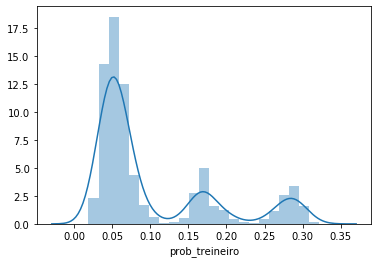

In [54]:
sns.distplot(resultado_rf['prob_treineiro'])

Existe uma concentração considerável de observações com probabilidade menor do que 0,1 e nenhum com probabilidade maior do que 0,5.

In [55]:
# observações com probabilidade maior do que 0,10
sum(resultado_rf['prob_treineiro']>0.10)

1326

In [57]:
# observações com probabilidade maior do que 0,20
sum(resultado_rf['prob_treineiro']>0.20)

618

O valor escolhido de corte será 0,20, fazendo com que qualquer observação com probabilidade maior seja considerada treineiro.

In [59]:
# cria coluna com o novo valor de corte
resultado_rf['IN_TREINEIRO'] = resultado_rf['prob_treineiro']>0.20
resultado_rf['IN_TREINEIRO'] = resultado_rf['IN_TREINEIRO'].astype('int64')

resultado_rf.head()

,NU_INSCRICAO,prob_treineiro,IN_TREINEIRO
0,ba0cc30ba34e7a46764c09dfc38ed83d15828897,0.034126,0
1,177f281c68fa032aedbd842a745da68490926cd2,0.039650,0
2,6cf0d8b97597d7625cdedc7bdb6c0f052286c334,0.287920,1
3,5c356d810fa57671402502cd0933e5601a2ebf1e,0.167380,0
4,df47c07bd881c2db3f38c6048bf77c132ad0ceb3,0.043272,0


In [60]:
# classificações na base de teste
resultado_rf['IN_TREINEIRO'].value_counts()

0    3952
1     618
Name: IN_TREINEIRO, dtype: int64

In [61]:
# cria o arquivo de submissão
resultado_rf.to_csv('answer.csv')